#PUC-Rio | Curso de Pós-Gradução em Engenharia de Software


---



###Notebook de resolução do problema de Machine Learning

<br>

<p>
Este notebook contém o conjunto de códigos destinados à avaliação, escolha e treino do modelo de "machine learning" empregado no projeto de MVP.
</p>

<p>
O dataset escolhido para a resolução do problema de classificação foi o "Steam Dataset", que contém informações sobre jogos, incluindo gêneros, categorias, e o preço dos jogos. O objetivo é classificar os jogos em faixas de preço com base nas características fornecidas.
</p>

<p>
O campo "price" foi categorizado em três faixas: "Baixo", "Médio" e "Alto", correspondendo a diferentes intervalos de preço. As variáveis de entrada incluem informações como os gêneros e as categorias dos jogos, permitindo ao modelo prever a faixa de preço de um jogo.
</p>

<p>
O modelo adotado foi a Árvore de Classificação ("DecisionTreeClassifier"), que apresentou os melhores resultados em termos de acurácia e consistência na classificação dos jogos em suas respectivas faixas de preço.
</p>

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

# Modelos de Classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Utilidades diversas
from sklearn import datasets
from pickle import dump, load
import matplotlib.pyplot as plt


## Carga do Dataset

In [ ]:
# Informa a URL de importação do dataset

url = "https://raw.githubusercontent.com/LeonardoDFKleuser/MVP_ML_PUC_RIO/main/meu_app_api/database/steam.csv"

# Lê o arquivo
df = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


## Separação em conjunto de treino e conjunto de teste com holdout



In [ ]:
# Definir o tamanho do conjunto de teste e a semente aleatória
test_size = 0.80
seed = 7

# Recarregar o dataset e garantir que as colunas estejam disponíveis
input_columns = ['genres', 'categories']
output_column = 'price'

# Transformar as colunas de entrada (genres, categories) em representações numéricas
X = pd.get_dummies(df[input_columns], drop_first=True)

# Definir a coluna de saída (price)
y = df[output_column]

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=seed)

# Definir as faixas de preço
price_bins = [0, 5, 15, np.inf]  # Faixas de preço: até 5, entre 5 e 15, e acima de 15
price_labels = ['Baixo', 'Médio', 'Alto']  # Nome das categorias

# Criar a coluna de categorias de preços para treino e teste
y_train_class = pd.cut(y_train, bins=price_bins, labels=price_labels)
y_test_class = pd.cut(y_test, bins=price_bins, labels=price_labels)

# Escalar os dados de entrada
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verificar a presença de NaNs em y_train_class
print(y_train_class.isna().sum())  # Ver quantos valores NaN existem

# Remover linhas com NaNs de y_train_class e X_train_scaled
mask = ~y_train_class.isna()
X_train_clean = X_train_scaled[mask]
y_train_clean = y_train_class[mask]

# Remover da mesma forma em y_test_class
mask_test = ~y_test_class.isna()
X_test_clean = X_test_scaled[mask_test]
y_test_clean = y_test_class[mask_test]

# Agora que y_train_class e y_test_class foram definidas, você pode continuar com a modelagem


507


## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.559292 (0.017091)
CART: 0.585173 (0.012380)
NB: 0.302157 (0.015913)
SVM: 0.585581 (0.016673)


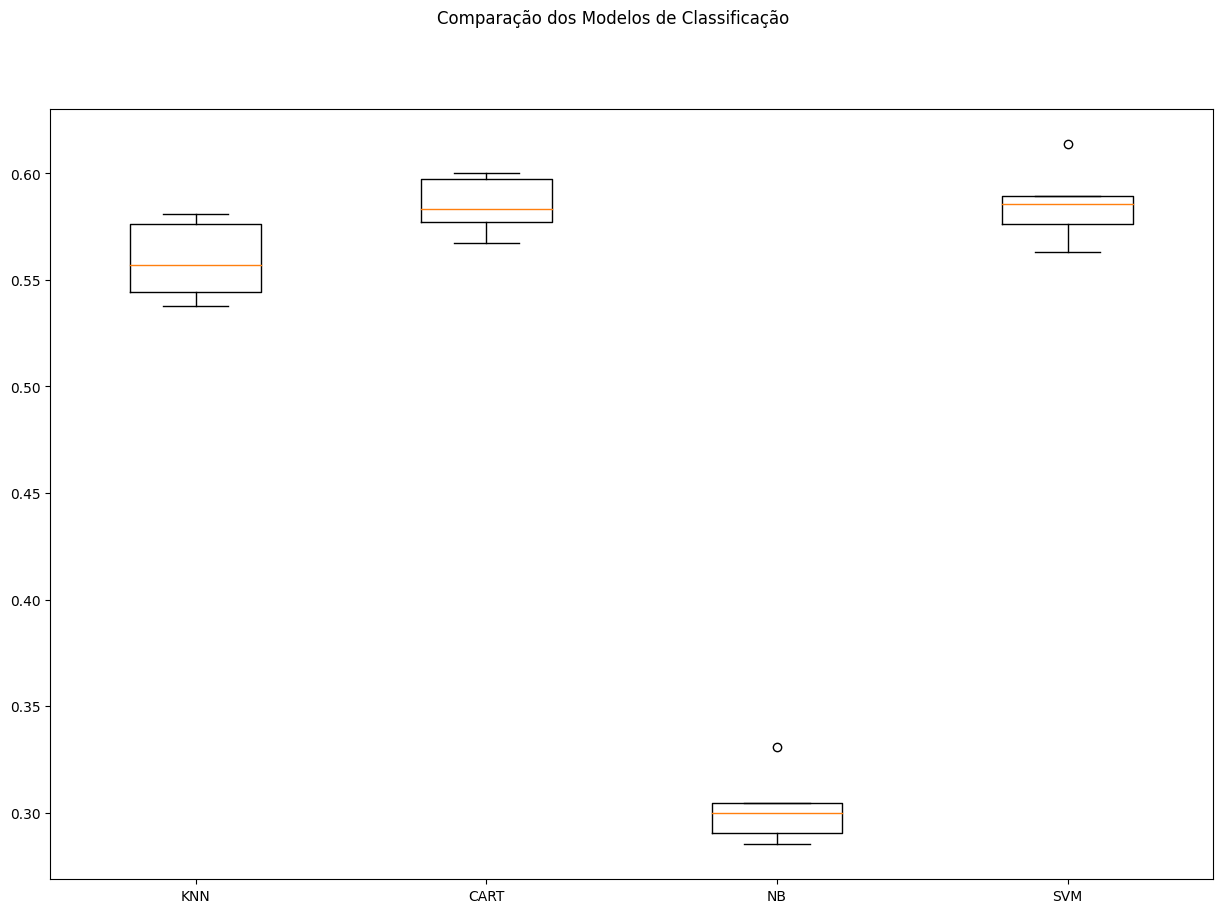

In [ ]:


# Lista que armazenará os classificadores
models = []

# Criando os modelos de classificação e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Definir o KFold com 5 divisões
kfold = KFold(n_splits=5, shuffle=True, random_state=7)

# Avaliação dos modelos usando validação cruzada com dados limpos
for name, model in models:
    cv_results = cross_val_score(model, X_train_clean, y_train_clean, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos de Classificação')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.559 (0.017)
CART-orig: 0.586 (0.010)
NB-orig: 0.302 (0.016)
SVM-orig: 0.586 (0.017)
KNN-padr: 0.558 (0.016)
CART-padr: 0.585 (0.012)
NB-padr: 0.302 (0.016)
SVM-padr: 0.585 (0.016)
KNN-norm: 0.560 (0.019)
CART-norm: 0.585 (0.013)
NB-norm: 0.302 (0.017)
SVM-norm: 0.595 (0.008)


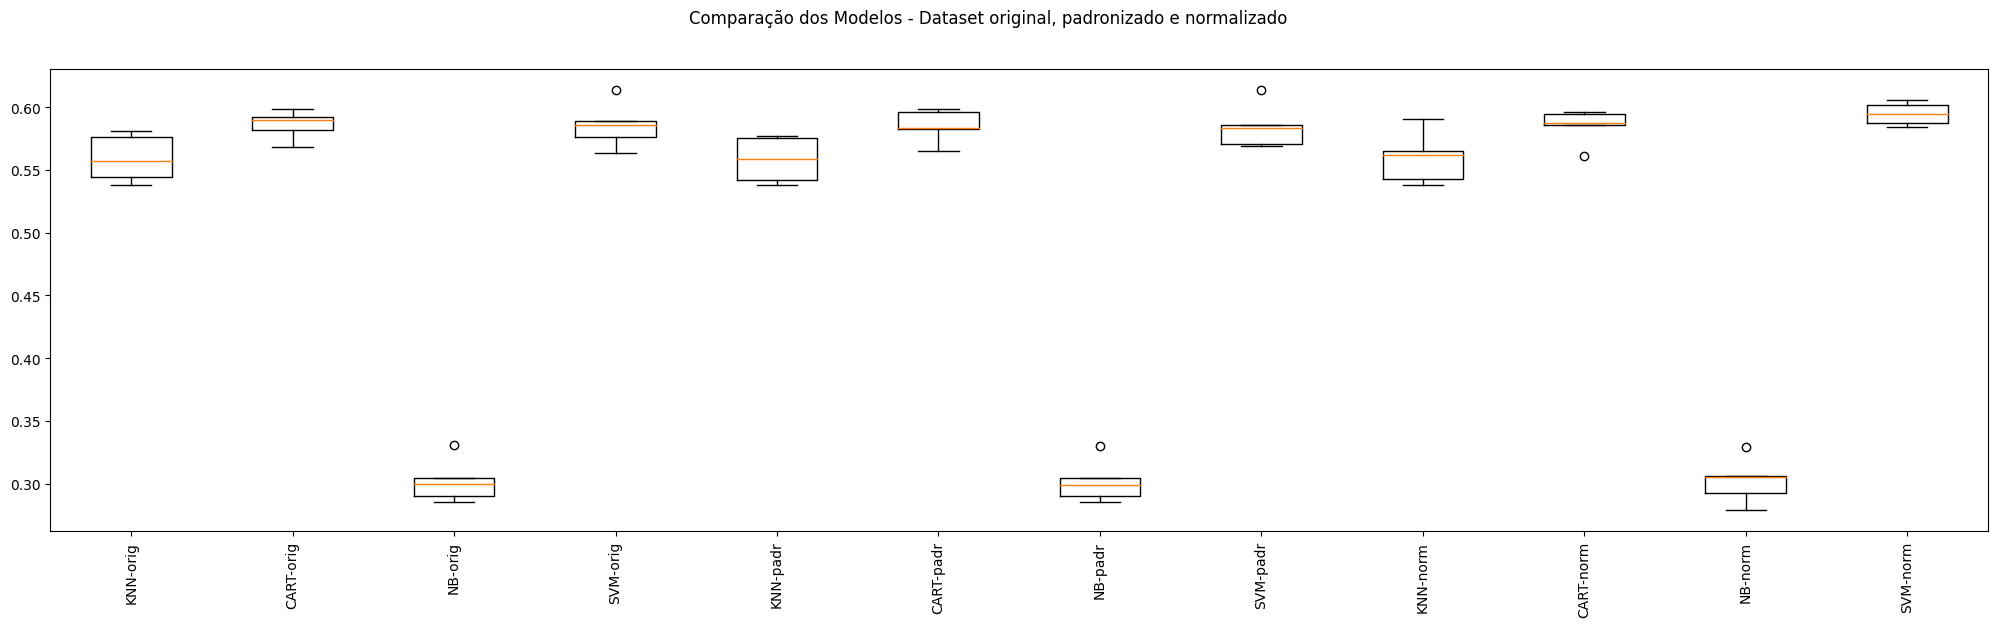

In [ ]:
# Definir a semente global
np.random.seed(7)

# Definir o KFold com 5 divisões
kfold = KFold(n_splits=5, shuffle=True, random_state=7)

# Listas para armazenar os pipelines e os resultados
pipelines = []
results = []
names = []

# Criando os classificadores
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Criando as transformações
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original (sem transformações)
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train_clean, y_train_clean, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [ ]:
# Definir a semente global
np.random.seed(7)

# Definir o KFold com 5 divisões
kfold = KFold(n_splits=5, shuffle=True, random_state=7)

# Definindo os componentes do pipeline
cart = ('CART', DecisionTreeClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Criar os pipelines
pipelines = []
pipelines.append(('CART-orig', Pipeline(steps=[cart])))
pipelines.append(('CART-padr', Pipeline(steps=[standard_scaler, cart])))
pipelines.append(('CART-norm', Pipeline(steps=[min_max_scaler, cart])))

# Definir o grid de parâmetros para DecisionTreeClassifier
param_grid = {
    'CART__max_depth': [5, 10, 15, 20, None],
    'CART__min_samples_split': [2, 10, 20],
    'CART__min_samples_leaf': [1, 5, 10]
}

# Prepara e executa o GridSearchCV para cada pipeline
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
    grid.fit(X_train_clean, y_train_clean)

    # Imprimir a melhor configuração encontrada
    print("Melhor configuração para %s: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Melhor configuração para CART-orig: 0.592910 usando {'CART__max_depth': None, 'CART__min_samples_leaf': 5, 'CART__min_samples_split': 2}
Melhor configuração para CART-padr: 0.592910 usando {'CART__max_depth': None, 'CART__min_samples_leaf': 5, 'CART__min_samples_split': 10}
Melhor configuração para CART-norm: 0.592503 usando {'CART__max_depth': None, 'CART__min_samples_leaf': 5, 'CART__min_samples_split': 2}


## Finalização do Modelo



In [6]:


# Preparação do modelo com o conjunto de treino
scaler = StandardScaler().fit(X_train_clean)  # Ajuste do scaler com o conjunto de treino
rescaledX_train = scaler.transform(X_train_clean)  # Aplicação da padronização no conjunto de treino

# Treinamento do modelo de DecisionTree
model = DecisionTreeClassifier()  # Você pode ajustar os hiperparâmetros conforme a otimização anterior
model.fit(rescaledX_train, y_train_clean)

# Aplicação da padronização no conjunto de teste
rescaledX_test = scaler.transform(X_test_clean)  # Aplicação da padronização no conjunto de teste

# Predições e avaliação
predictions = model.predict(rescaledX_test)
print(f"Acurácia no conjunto de teste: {accuracy_score(y_test_clean, predictions):.3f}")


Acurácia no conjunto de teste: 0.591


In [7]:
# Converter `y` (preço) para categorias (faixas de preço)

y_class = pd.cut(y, bins=price_bins, labels=price_labels)

# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X)  # Ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X)  # Aplicação da padronização com TODO o dataset

# Remover linhas com NaNs
mask = ~y_class.isna()
rescaledX_clean = rescaledX[mask]
y_class_clean = y_class[mask]

# Usar um modelo de classificação com os dados limpos
model = DecisionTreeClassifier()  # Para classes (faixas de preço)
model.fit(rescaledX_clean, y_class_clean)  # Ajustar o modelo com os dados limpos



DecisionTreeClassifier()

## Simulando a aplicação do modelo em dados não vistos

In [9]:
# Novos dados - não sabemos a faixa de preço!
data = {
        'genres': ['Action', 'Adventure', 'RPG'],  # Exemplo de novos dados
        'categories': ['Multi-player', 'Single-player', 'Co-op']  # Exemplos de novas categorias
        }

# Criar um DataFrame com os novos dados
entrada = pd.DataFrame(data)

# Transformar as colunas de entrada usando pd.get_dummies (igual ao que foi feito no treinamento)
entrada_transformada = pd.get_dummies(entrada, drop_first=True)

# Garantir que as colunas de 'entrada_transformada' coincidam com as colunas usadas no treinamento
# Preencher as colunas que faltam com zeros
entrada_transformada = entrada_transformada.reindex(columns=X_train.columns, fill_value=0)

# Padronizar os novos dados usando o scaler treinado
rescaledEntradaX = scaler.transform(entrada_transformada)

# Fazer a predição com o modelo treinado
predictions = model.predict(rescaledEntradaX)

# Mostrar as previsões
print(f"Predições para os novos dados: {predictions}")


Predições para os novos dados: ['Médio' 'Baixo' 'Alto']


In [10]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

['Médio' 'Baixo' 'Alto']


# Nova seção

In [21]:

# Informa a URL de importação do dataset Steam
url = "https://raw.githubusercontent.com/LeonardoDFKleuser/MVP_ML_PUC_RIO/main/meu_app_api/database/steam.csv"

# Lê o arquivo CSV diretamente da URL
dataset = pd.read_csv(url, delimiter=',')

# Verificar as primeiras linhas do dataset para entender sua estrutura
print(dataset.head())

# Definir as colunas de entrada (variáveis preditoras) e a coluna alvo (price ou categorizada)
# Exemplo com 'genres' e 'categories' como variáveis preditoras e 'price' como alvo
input_columns = ['genres', 'categories']  # As colunas que serão usadas como preditores
output_column = 'price'  # A coluna alvo

# Transformar as colunas de entrada em variáveis dummificadas (necessário para o modelo)
X = pd.get_dummies(dataset[input_columns], drop_first=True)

# Definir a variável alvo (Y) como sendo a coluna 'price' diretamente
Y = dataset[output_column]

# Se preferir usar faixas de preço, você pode fazer o seguinte:
# price_bins = [0, 5, 15, np.inf]  # Definir as faixas de preço
# price_labels = ['Baixo', 'Médio', 'Alto']  # Nome das categorias
# Y = pd.cut(dataset[output_column], bins=price_bins, labels=price_labels)

# Verificar as dimensões das variáveis preditoras e da variável alvo
print(f"Dimensões de X (variáveis preditoras): {X.shape}")
print(f"Dimensões de Y (variável alvo): {Y.shape}")


   appid                       name release_date  english         developer  \
0     10             Counter-Strike   2000-11-01        1             Valve   
1     20      Team Fortress Classic   1999-04-01        1             Valve   
2     30              Day of Defeat   2003-05-01        1             Valve   
3     40         Deathmatch Classic   2001-06-01        1             Valve   
4     50  Half-Life: Opposing Force   1999-11-01        1  Gearbox Software   

  publisher          platforms  required_age  \
0     Valve  windows;mac;linux             0   
1     Valve  windows;mac;linux             0   
2     Valve  windows;mac;linux             0   
3     Valve  windows;mac;linux             0   
4     Valve  windows;mac;linux             0   

                                          categories  genres  \
0  Multi-player;Online Multi-Player;Local Multi-P...  Action   
1  Multi-player;Online Multi-Player;Local Multi-P...  Action   
2              Multi-player;Valve Anti-Cheat

In [27]:
# Verificar se há NaNs em X ou Y_class antes de dividir
print(f"NaNs em X: {X.isna().sum().sum()}")
print(f"NaNs em Y_class: {Y_class.isna().sum()}")

# Remover ou preencher valores NaN em X e Y_class
X_clean = X.fillna(0)  # Preencher valores NaN com 0, por exemplo
Y_class_clean = Y_class.fillna("Baixo")  # Preencher valores NaN em Y_class com a classe mais baixa

# Divide os dados em treino e teste (33% para teste)
X_train, X_test, Y_train, Y_test = train_test_split(X_clean, Y_class_clean, test_size=0.33, random_state=7)

# Cria o modelo de classificação
modelo = DecisionTreeClassifier()

# Treina o modelo
modelo.fit(X_train, Y_train)

# Verificar o desempenho no conjunto de teste
train_accuracy = modelo.score(X_train, Y_train)
test_accuracy = modelo.score(X_test, Y_test)

# Exibir os resultados
print(f"Acurácia no conjunto de treino: {train_accuracy:.3f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.3f}")

NaNs em X: 0
NaNs em Y_class: 2560
Acurácia no conjunto de treino: 0.827
Acurácia no conjunto de teste: 0.640


In [33]:
# Salva o modelo no disco
filename = 'model.pkl'
dump(modelo, open(filename, 'wb'))

In [34]:
# Algum tempo depois...
# Carrega o modelo do disco
loaded_model = load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

0.6402909904868495


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
